# Rossmann Store Sales

### Problem Statement

 Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### Feature Description

* Most of the fields are self-explanatory. The following are descriptions for those that aren't.

Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### Importing the Libraries

In [1]:
#Basic libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
#SKLEARN libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
#Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
store_data = pd.read_csv("store.csv")

In [7]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [9]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [10]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


## Exploratory Data Analysis(EDA)

In [11]:
print(train_data.shape)
print(store_data.shape)
print(test_data.shape)

(1017209, 9)
(1115, 10)
(41088, 8)


In [12]:
print(train_data.dtypes,'\n')
print(store_data.dtypes)

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object 

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object


## Feature Engineering

In [13]:
train_data['Month'] = train_data['Date'].str.split('-').str[1]
train_data['Day'] = train_data['Date'].str.split('-').str[2]
train_data['Year'] = train_data['Date'].str.split('-').str[0]

In [14]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Day,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,07,31,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,07,31,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,07,31,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,07,31,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,07,31,2015


In [10]:
train_data = train_data.reindex(columns=['Store','Date','Day','Month','Year','DayOfWeek','Customers','Open','Promo','StateHoliday','SchoolHoliday','Sales'])

In [15]:
train_data.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Day,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,07,31,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,07,31,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,07,31,2015


In [16]:
train_data['Year'].value_counts()

2013    406974
2014    373855
2015    236380
Name: Year, dtype: int64

In [17]:
train_data.StateHoliday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [18]:
train_data.loc[train_data['StateHoliday']==0,'StateHoliday']='0'

In [19]:
train_data.StateHoliday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [20]:
train_data.drop('Date',axis=1,inplace=True)

In [21]:
train_data.shape

(1017209, 11)

In [22]:
store_data.Promo2SinceYear.value_counts()

2011.0    128
2013.0    120
2014.0     95
2012.0     81
2009.0     73
2010.0     64
2015.0     10
Name: Promo2SinceYear, dtype: int64

In [19]:
store_data.Promo2SinceWeek.value_counts()

14.0    81
40.0    77
31.0    44
10.0    42
5.0     39
37.0    35
1.0     35
45.0    34
13.0    34
22.0    33
18.0    29
35.0    25
9.0     14
27.0    11
36.0    10
48.0     9
39.0     6
23.0     5
44.0     3
49.0     1
6.0      1
26.0     1
50.0     1
28.0     1
Name: Promo2SinceWeek, dtype: int64

In [23]:
store_data['CompetitionOpenSinceMonth'].value_counts()

9.0     125
4.0      94
11.0     92
3.0      70
7.0      67
12.0     64
10.0     61
6.0      50
5.0      44
2.0      41
8.0      39
1.0      14
Name: CompetitionOpenSinceMonth, dtype: int64

In [24]:
store_data['CompetitionOpenSinceYear'].value_counts()

2013.0    83
2012.0    82
2014.0    70
2005.0    62
2010.0    55
2008.0    54
2011.0    54
2009.0    54
2007.0    48
2006.0    47
2015.0    38
2002.0    27
2004.0    22
2003.0    19
2001.0    16
2000.0    10
1999.0     8
1990.0     5
1995.0     2
1994.0     2
1900.0     1
1961.0     1
1998.0     1
Name: CompetitionOpenSinceYear, dtype: int64

In [25]:
store_data.PromoInterval.value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [26]:
train_data.isna().sum()

Store            0
DayOfWeek        0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
Month            0
Day              0
Year             0
dtype: int64

In [30]:
store_data.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [32]:
test_data.isna().sum()

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [77]:
Test_data.Open.value_counts()

1.0    35093
0.0     5984
Name: Open, dtype: int64

In [34]:
test_data['Open']=test_data['Open'].fillna(1)

In [81]:
test_data.isna().sum().sum()

0

In [35]:
test_data['Day'] = test_data['Date'].str.split('-').str[2]
test_data['Month']= test_data['Date'].str.split('-').str[1]
test_data['Year']= test_data['Date'].str.split('-').str[0]

In [36]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year
0,1,1,4,2015-09-17,1.0,1,0,0,17,09,2015
1,2,3,4,2015-09-17,1.0,1,0,0,17,09,2015
2,3,7,4,2015-09-17,1.0,1,0,0,17,09,2015
3,4,8,4,2015-09-17,1.0,1,0,0,17,09,2015
4,5,9,4,2015-09-17,1.0,1,0,0,17,09,2015


In [37]:
test_data.drop("Date",axis=1,inplace=True)

In [92]:
test_data = test_data.reindex(columns=['Id','Store','Day','Month','Year','DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday',])

In [38]:
test_data.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year
0,1,1,4,1.0,1,0,0,17,09,2015
1,2,3,4,1.0,1,0,0,17,09,2015
2,3,7,4,1.0,1,0,0,17,09,2015
3,4,8,4,1.0,1,0,0,17,09,2015
4,5,9,4,1.0,1,0,0,17,09,2015


### Handling NULL values in Store_data

In [39]:
store_data['CompetitionDistance'] = store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].mean())

In [40]:
store_data['Promo2SinceWeek']=store_data['Promo2SinceWeek'].ffill().bfill()

In [41]:
store_data['Promo2SinceYear']=store_data['Promo2SinceYear'].ffill().bfill()

In [43]:
store_data['CompetitionOpenSinceYear'] = store_data['CompetitionOpenSinceYear'].ffill().bfill()

In [45]:
store_data['CompetitionOpenSinceMonth'] = store_data['CompetitionOpenSinceMonth'].fillna(store_data['CompetitionOpenSinceMonth'].median())

In [46]:
store_data['PromoInterval'] = store_data['PromoInterval'].fillna(0)

In [47]:
store_data['PromoInterval'] = store_data['PromoInterval'].map({0:0, 'Jan,Apr,Jul,Oct':1, 'Feb,May,Aug,Nov':2, 'Mar,Jun,Sept,Dec':3})

In [48]:
store_data.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

### Merging the train & store data

In [49]:
data = pd.merge(train_data,store_data, on='Store', how='left')

In [50]:
data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Day,Year,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,07,31,2015,c,a,1270.0,9.0,2008.0,0,13.0,2010.0,0
1,2,5,6064,625,1,1,0,1,07,31,2015,a,a,570.0,11.0,2007.0,1,13.0,2010.0,1
2,3,5,8314,821,1,1,0,1,07,31,2015,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,1
3,4,5,13995,1498,1,1,0,1,07,31,2015,c,c,620.0,9.0,2009.0,0,14.0,2011.0,0
4,5,5,4822,559,1,1,0,1,07,31,2015,a,a,29910.0,4.0,2015.0,0,14.0,2011.0,0


In [51]:
data.shape

(1017209, 20)

In [52]:
data.dtypes

Store                          int64
DayOfWeek                      int64
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
Month                         object
Day                           object
Year                          object
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                  int64
dtype: object

In [53]:
for i in ('Open','Promo','StateHoliday','SchoolHoliday','StoreType','Assortment','Promo2','PromoInterval'):
    data[i] = data[i].astype("category")

In [54]:
for i in ('Day','Month','Year'):
    data[i] = data[i].astype("int64")

In [55]:
data.dtypes

Store                           int64
DayOfWeek                       int64
Sales                           int64
Customers                       int64
Open                         category
Promo                        category
StateHoliday                 category
SchoolHoliday                category
Month                           int64
Day                             int64
Year                            int64
StoreType                    category
Assortment                   category
CompetitionDistance           float64
CompetitionOpenSinceMonth     float64
CompetitionOpenSinceYear      float64
Promo2                       category
Promo2SinceWeek               float64
Promo2SinceYear               float64
PromoInterval                category
dtype: object

### Visualization

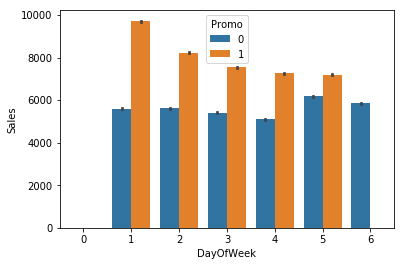

In [56]:
avg_hist_by_month = data[['Sales', 'Customers', 'Promo']].groupby(['Promo']).mean()
sns.barplot(x="DayOfWeek", y="Sales", hue="Promo", order=[0, 1, 2, 3, 4, 5, 6], data=data)

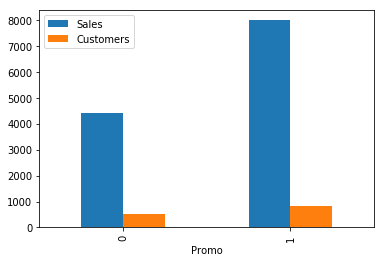

In [57]:
avg_promotion = data[['Sales', 'Customers', 'Promo']].groupby('Promo').mean()
avg_promotion.plot(kind='bar')

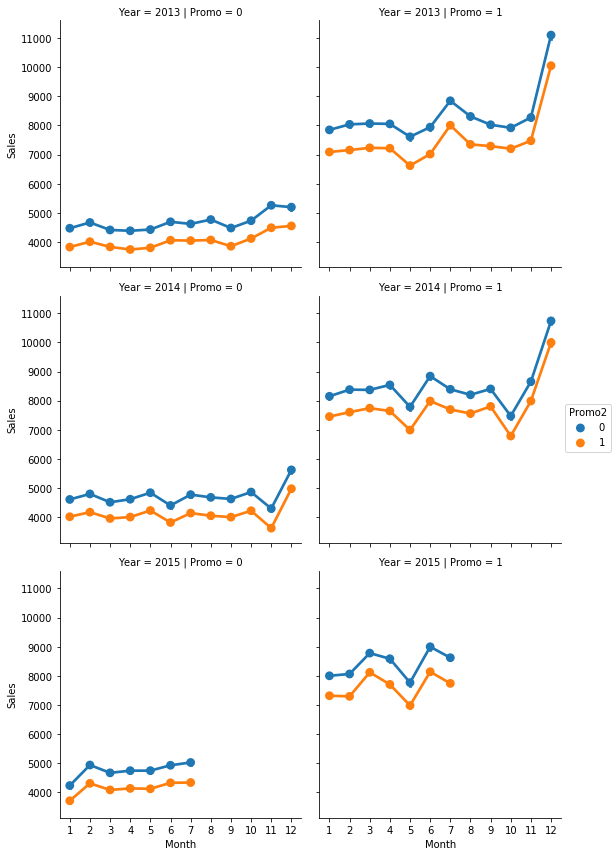

In [58]:
sns.factorplot(data = data, x ="Month", y = "Sales", 
               col = 'Promo', 
               hue = 'Promo2',
               row = "Year"
             )

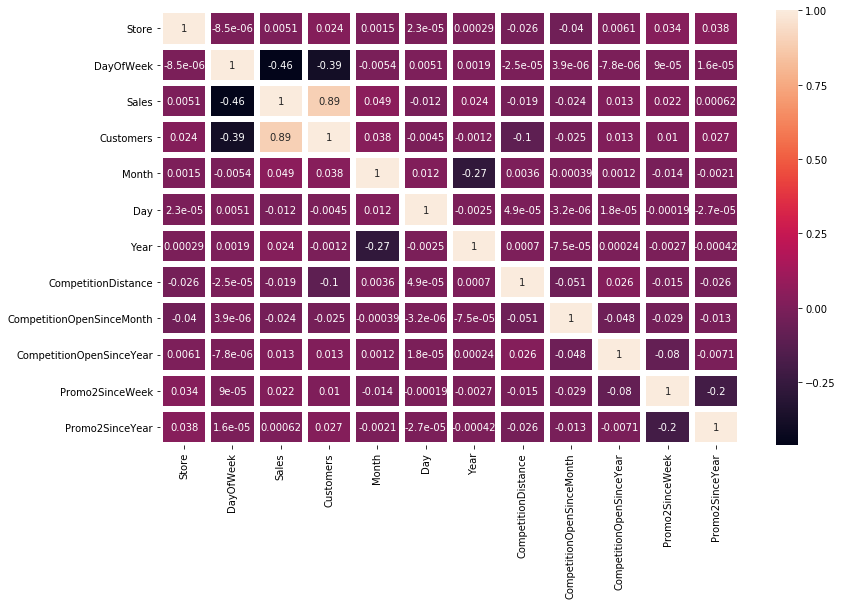

In [59]:
corr = data.corr()
fig, ax = plt.subplots(figsize=(13,8))
ax = sns.heatmap(corr,annot =True, linewidth = 5, cbar = True)

In [60]:
data = pd.get_dummies(data)

In [64]:
data.head()

,Store,DayOfWeek,Sales,Customers,Month,Day,Year,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,StoreType_d,Assortment_a,Assortment_b,Assortment_c,Promo2_0,Promo2_1,PromoInterval_0,PromoInterval_1,PromoInterval_2,PromoInterval_3
0,1,5,5263,555,7,31,2015,1270.0,9.0,2008.0,...,0,1,0,0,1,0,1,0,0,0
1,2,5,6064,625,7,31,2015,570.0,11.0,2007.0,...,0,1,0,0,0,1,0,1,0,0
2,3,5,8314,821,7,31,2015,14130.0,12.0,2006.0,...,0,1,0,0,0,1,0,1,0,0
3,4,5,13995,1498,7,31,2015,620.0,9.0,2009.0,...,0,0,0,1,1,0,1,0,0,0
4,5,5,4822,559,7,31,2015,29910.0,4.0,2015.0,...,0,1,0,0,1,0,1,0,0,0


### Splitting Train & Test data

In [65]:
X = data.drop('Sales',axis=1)
Y = data['Sales']

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=123, test_size=0.3)

In [66]:
print(x_train.shape)
print(y_train.shape,'\n')

print(x_test.shape)
print(y_test.shape)

(712046, 34)
(712046,) 

(305163, 34)
(305163,)


## Model Building Decision Tree

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [67]:
dt=DecisionTreeRegressor(max_depth=45).fit(x_train,y_train)

In [79]:
from sklearn.pipeline import Pipeline

pipe_rf = Pipeline([('rfr', RandomForestRegressor(random_state=42))])

In [80]:
n_estimators = [5,6]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1,4,5,]
# Minimum number of samples required to split a node
min_samples_split = [2,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]


In [81]:
grid_param_rf= [{'rfr__n_estimators': n_estimators,
                 'rfr__max_features': max_features,
                 'rfr__max_depth': max_depth,
                 'rfr__min_samples_split': min_samples_split,
                 'rfr__min_samples_leaf': min_samples_leaf}]

In [82]:
from sklearn.model_selection import GridSearchCV

dt_grid = GridSearchCV(pipe_rf, param_grid=grid_param_rf, cv=5)

dt_grid.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('rfr',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_split=2,
                                                              min_weight_fraction_leaf=0.0,
                      

In [83]:
test_pred = dt_grid.predict(x_test)

In [84]:
train_pred = dt_grid.predict(x_train)

In [85]:
print(dt_grid.score(x_train, y_train))
print(dt_grid.score(x_test, y_test))

0.8798492496052231
0.8802039552507231


In [86]:
r2_score(y_train,train_pred)

0.8798492496052231

In [87]:
r2_score(y_test, test_pred)

0.8802039552507231